<a href="https://colab.research.google.com/github/RobertoMejiaLacayo/reimagined-traffic-jam/blob/main/traffic_jam_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An Intro to Complexity Through Traffic Jams (Roberto's Edition)

Some code sourced from Think Complexity, 2nd edition.
Made for the COMP 215 final

Traffic jams are a common problem that we all experience while driving. Scientists use computer models to study how traffic jams happen and how we can prevent them. By studying how these computer characters behave, scientists can understand why traffic jams happen and how we can avoid them. This is important because traffic jams can cause accidents, waste time, and harm the environment. By using computer models to study traffic jams, we can make our roads safer and more efficient.

-

Roberto Mejia Lacayo
April 17 2023

First, we'll handle all the imports we need to get the job done.

In [1]:
%matplotlib inline

import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors
from time import sleep
from IPython.display import clear_output

Setting up a dictionary and functions to use later on for data visualization too! 
I took these from previous labs, so you should be relatively familiar with this code.

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

Using the Driver class from the textbook (we don't need to worry about coming up with these mechanics for the traffic jam model at our level, we're just using them)

One thing to note: Notice how the choose_acceleration() takes in a parameter that we don't actually use. The reason behind this is because we want a uniform acceleration between all cars to best see how traffic jams become unjammed in an ideal world. (However, in an ideal world we wouldn't have any, which is why we're studying them in order to get closer to that)

In [3]:
class Driver:
    def __init__(self, loc, speed=4):
        """Initialize the attributes.

        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed

    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.

        dist: distance from the car in front

        returns: 1 every time for now, regardless of distance
        """
        return 1

    def set_odometer(self):
        self.start = self.loc

    def read_odometer(self):
        return self.loc - self.start

Now we're getting to the real meat of the project: Completing the Cell2D class that we're going to use to make this behave the way it's supposed to!

Something to note here: this Cell2D class is likely applicable to a large range of classes and labs your textbook covers as it is barebones and has an animate() method

In [4]:
class Cell2D:
    """Universial 2D cellular automata array"""

    def __init__(self, n, m=None):
        """Initializes the attributes.
        n: number of rows
        m: number of columns
        """

        # A neat trick i picked up recently to allow all rectangular shapes !
        # however, usually we encourage square shaped CAs just because we're weirdos in this class :P
        if m == None:
          m = n
        else:
          m = m

        # setting default array cells to all 0s
        self.array = np.zeros((n, m), np.uint8)

    #pretty much just calls that code for visualization.
    def draw(self):
        """Draws the array.
        """
        plot_2D_array(self.array, DEFAULT_IMSHOW_OPTIONS)


    # this was largely taken from a previous Animation2D and other labs and reworked to fit here.
    def animate(self, frames, interval=None):
        """Animate the CA.
        
        frames: number of steps to draw in this animation
        interval: time between frames in seconds
        """

        plt.figure()
        try:
            for i in range(frames-1):
                self.draw()
                plt.show()
                #change interval from None to a value when running this to increase interval between frames
                if interval:
                    sleep(interval)
                self.step()
                clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

Also just taking the Highway class from the textbook. Same story as the Driver class, really - no changes made here.

In [5]:
class Highway(Cell2D):
    max_acc = 1
    min_acc = -10
    speed_limit = 40

    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.

        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]

        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]

    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)

    def move(self, driver):
        """Updates `driver`.

        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc

        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)

        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)

        # if current speed would collide with next driver, stop
        if speed > dist:
            speed = 0
            self.crashes += 1

        # update speed and loc
        driver.speed = speed
        driver.loc += speed

    def distance(self, driver):
        """Distance from `driver` to next driver.

        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist

    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 

    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])

    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)

        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)

        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.

        Transforms from (row, col) to (x, y).

        drivers: sequence of Driver
        r: radius of the circle

        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

Now, let's test and see what we've come up with!

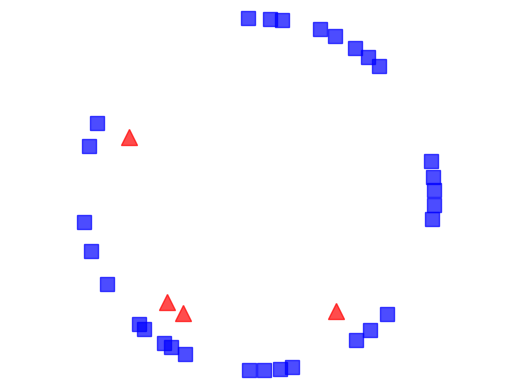

57


In [6]:
highway = Highway(30, eps=0.02)
highway.animate(frames=50, interval=0.2)

#printing the crashes for fun - I would hope this number is as close to 0 as possible...
print(highway.crashes)

# Mini Analysis of a Quick Run:

As we can see, even with uniform acceleration and a relatively conservative simulation, we can see the model acting pretty realistically! The number of crashes is somewhat alarming but good thing this is a simulation and not a real life scenario. ICBC wouldn't be too happy, haha

Let's run some more simulations to get a better picture of this model. This is sourced straight from the textbook's notebook and is meant to show the correlation between `eps` and the average speed of drivers in the highway model.

`eps` is the variability in speed in case you had forgotten.

In [7]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

The textbook also provides us with most of the code we need to plot a graph to better visualize the results of that experiment. All I've done is reworked it to better fit in this notebook, and given it a blood red palette to showcase the dangers of driving too fast!

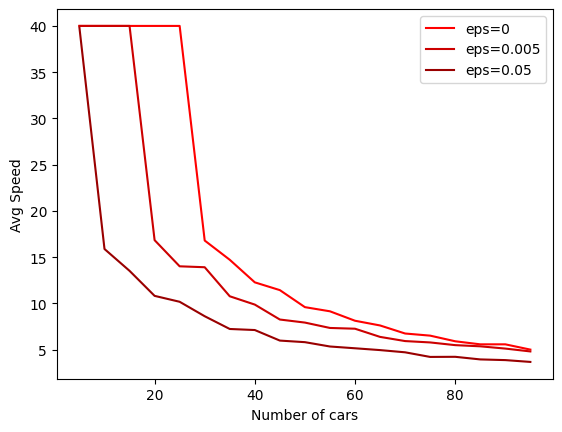

In [8]:
eps_list = [0.0, 0.005, 0.05]

# Define the shades of red to use for each value of eps
colors = [(1.0, 0.0, 0.0), (0.8, 0.0, 0.0), (0.6, 0.0, 0.0)]

# Plot the data for each value of eps with the corresponding shade of red
for i, eps in enumerate(eps_list):
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps, color=colors[i])

# Add axis labels and legend
plt.xlabel('Number of cars')
plt.ylabel('Avg Speed')
plt.legend()

# Show the plot
plt.show()




So, what does this little experiment tell us? Well, following that earlier comment where I mentioned this being pretty realistic for a simple model, this graph shows how both a higher number of cars and a higher level of velocity variability ends up lowering the average speed. This is likely because of the congestion that results from too many cars driving near each other thanks to inconsistencies in speed, as well as just having lots of cars sharing the road.